## Sequence Models  - Recurrent Neural Network


Links - https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

1. Why do we use batching 
2. Batching for sequence models
3. Padding and packing in PyTorch
4. Training with batched dataset
5. Comparison of performance with batching and on GPU

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string, random, time, math

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output, Image
from google.colab import files
from tqdm import tqdm_notebook

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**How batching improves the performance**

1. Vectorisation - data paralelisation
2. Aggregated gradient computation - reduces variance in parameter updates when training

**Ways to batch sequence data**

1. feeding the first letter of each word as batch and concatenating them.
2. Padding the empty letter 
3. sorting the words/names in ascending order
4. Packing the sorted tensor into one single tensor

## 1. Dataset

Task - Given the name we have to identify the language (classifcation task)

The name is string here and we need to read each character in sequence and built a model based on it 


In [3]:
languages = []
data = []

X = []
Y = []

file_path = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/names&languages.txt'
with open(file_path,'r') as file:
  for line in file:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    Y.append(lang)
    data.append((name,lang))
    
n_languages = len(languages)
n_languages


18

In [4]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


## 2. Train test split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=0)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

16040 4010 16040 4010


In [6]:
print(X_train[0:10])

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko']


## 3. Batching the data

1. Padding 
2. Packing 

### 3.1 Padding

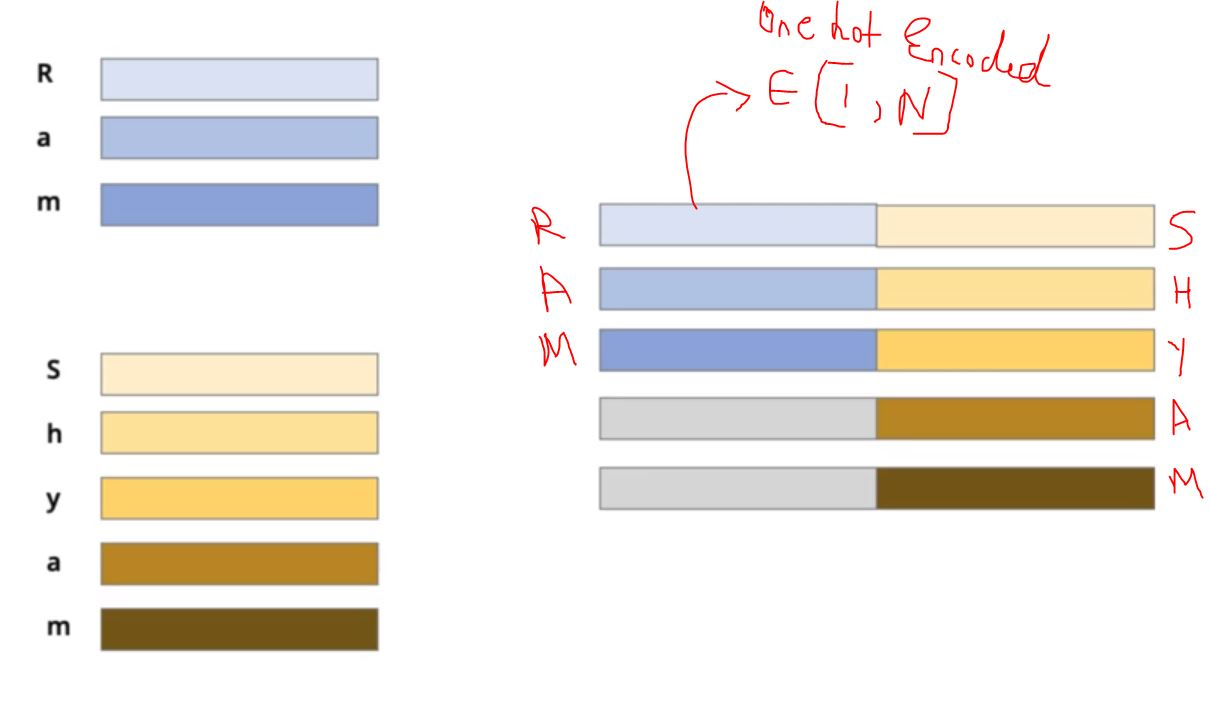

In [7]:
image_file = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/Pictures/Padding Algorithm.JPG'
Image(image_file, width=900, height=500)

In [8]:
ascii_letters = string.ascii_letters+".,;"
print(len(ascii_letters))
ascii_letters.find('A')

55


26

In [9]:
X_input = np.zeros(shape=(len(X),len(ascii_letters)))
X_input.shape             

(20050, 55)

In [10]:
def encode_name(name):
  one_hot_encoded = torch.zeros(size=(len(name),1,len(ascii_letters)))
  
  for pos,letter in enumerate(name):
    index = ascii_letters.find(letter)
    one_hot_encoded[pos][0][index] = 1
    
  return one_hot_encoded

def encode_language(language):
  return torch.tensor([languages.index(language)])

def encode_languages(langs):
  stack = []
  for lang in langs:
    stack.append(torch.tensor(languages.index(lang)))
  return torch.stack(stack,dim=0)
  
encode_languages(['Portuguese','Russian','Irish'])

tensor([ 0, 13,  1])

In [0]:
## encoding the letters into sequence of indices 
names = ['Shyam','Ram']

def padding(names):
  
  max_word = np.max([len(name) for name in names])
  encoding  = torch.zeros(size=(max_word,len(names),len(ascii_letters)))
  for i,name in enumerate(names):
    for n,letter in enumerate(name):
      try:
        index = ascii_letters.index(letter)
      except:
        print(letter)
      encoding[n][i][index] = 1 
      
  return encoding

In [12]:
padding(names).size()

torch.Size([5, 2, 55])

In [13]:
# concatenate the letters in a batch
# this is only for visualization
encoding = padding(names)
concatenated = encoding.view((-1,encoding.size()[-1]))
for batch_letter in concatenated:
  if torch.sum(batch_letter) == 0:
    print('<pad>')
  else:
    print(ascii_letters[batch_letter.argmax()])

S
R
h
a
y
m
a
<pad>
m
<pad>


### 3.2 Packing

Pack the tensors in an array and return the batch sizes as well

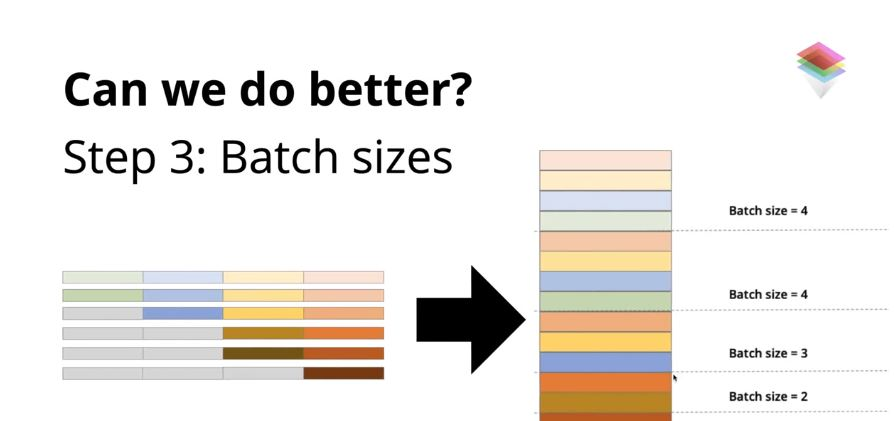

In [14]:
image_file = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/Pictures/Data_packing_algo.JPG'
Image(image_file)

**Packing algorithm is wirtten from scratch below**

In [15]:
## this is for visualization and debugging

def packing(names,verbose=False):  
  stack = []
  batch_sizes =[]
  if verbose:
    print(names)
  encoding = padding(names)
  for encode in encoding:
    batch_size = 0
    torch.cat
    for letter in encode:
      if letter.sum() != 0:
        l = int(torch.argmax(letter))
        batch_size +=1
        if verbose:
          print(ascii_letters[l])
        stack.append(letter)
    if verbose:
      print('Batch_size',batch_size)
      print('-'*30)
    batch_sizes.append(batch_size)

  return torch.stack(stack,dim=0), batch_sizes


tensor, batch_sizes = packing(names,verbose=True)
batch_sizes

['Shyam', 'Ram']
S
R
Batch_size 2
------------------------------
h
a
Batch_size 2
------------------------------
y
m
Batch_size 2
------------------------------
a
Batch_size 1
------------------------------
m
Batch_size 1
------------------------------


[2, 2, 2, 1, 1]

**however packing the sequence function is provided by torch.nn.utils.rnn package**

In [0]:
torch.nn.utils.rnn.pack_padded_sequence(padding(names), [len(x) for x in names])

PackedSequence(data=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [16]:
def batch_seq_data(X,Y,n_points=2,device='cpu', verbose=False):
  names,langs = [],[]
  for i in range(n_points):
    index = np.random.randint(len(X_train))
    names.append(X_train[index])
    langs.append(Y_train[index])
  names_rep = padding(names)
  lang_rep = encode_languages(langs)
  
  padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, [len(x) for x in names], enforce_sorted=False)
  
  if verbose:
    print(names_rep.size(), lang_rep.size())
    print('--')
    print(names_rep.size())
    print('---'*10)
    print('Names',names)
    print('Languages',langs)
    print(['length: '+str(len(name)) for name in names])
  
  return padded_names_rep.to(device), lang_rep.to(device)


padded_names_rep, lang_rep = batch_seq_data(X_train, Y_train,verbose=False)
lang_rep

tensor([13, 13])

In [21]:
names_rep, lang_rep = batch_seq_data(X_train,Y_train,n_points=2,device='cpu', verbose=False)
net(names_rep)

(tensor([[-2.8090, -2.8915, -2.9478, -2.8185, -2.8124, -2.9329, -2.9151, -2.8499,
          -2.8617, -3.1077, -2.9574, -2.8249, -2.9117, -2.9378, -2.7968, -2.9137,
          -2.9292, -2.8559],
         [-2.8637, -2.9297, -3.0007, -2.8091, -2.7787, -2.9330, -2.9412, -2.8448,
          -2.8050, -3.0814, -2.9422, -2.8316, -2.9579, -2.9428, -2.7955, -2.8490,
          -2.9146, -2.8595]], grad_fn=<LogSoftmaxBackward>),
 tensor([[[ 5.6591e-02,  1.6708e-01, -2.0004e-01,  1.4222e-01, -1.7105e-01,
            1.1236e-01, -1.4479e-01,  1.4402e-02, -2.1926e-04, -2.2620e-02,
            8.6754e-02,  2.1876e-02, -7.0776e-02,  1.4182e-01, -1.1758e-01,
           -4.7709e-02, -1.2890e-01,  2.1763e-01,  1.7341e-01,  1.3881e-01,
           -1.2710e-01, -4.7915e-02,  7.1156e-02, -1.7146e-01,  2.6071e-01,
            1.0191e-01,  2.1589e-01,  2.1834e-02,  3.7153e-02, -5.5078e-03,
           -6.9817e-02, -6.3001e-02,  3.4786e-02,  5.6724e-02,  3.5200e-02,
            4.5085e-03, -1.1870e-01,  9.9889e-02, 

## 4. Visualizing the data

Showing the distribution plot for the number of names per language

In [0]:
label_value_counts = {}
for lang in Y:
  if lang not in list(label_value_counts.keys()):
    label_value_counts.setdefault(lang,1)
  else:
    label_value_counts[lang] += 1    
print(label_value_counts)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


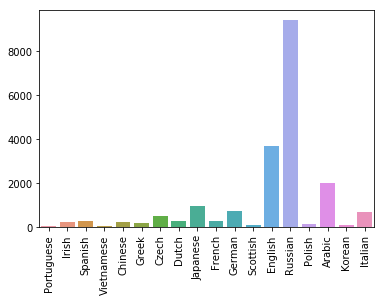

In [0]:
sns.barplot(list(label_value_counts.keys()), list(label_value_counts.values()))
plt.xticks(rotation=90)
plt.show()

Observation
1. Since the dataset is skewed,  the accuracy shouldn't be checked for overall triainset but it should be evaluated on basis per class accuracy
2. there are sevaral ways to deal with skewed data, but here uniform sampling is adopted while batching

## 5. Model

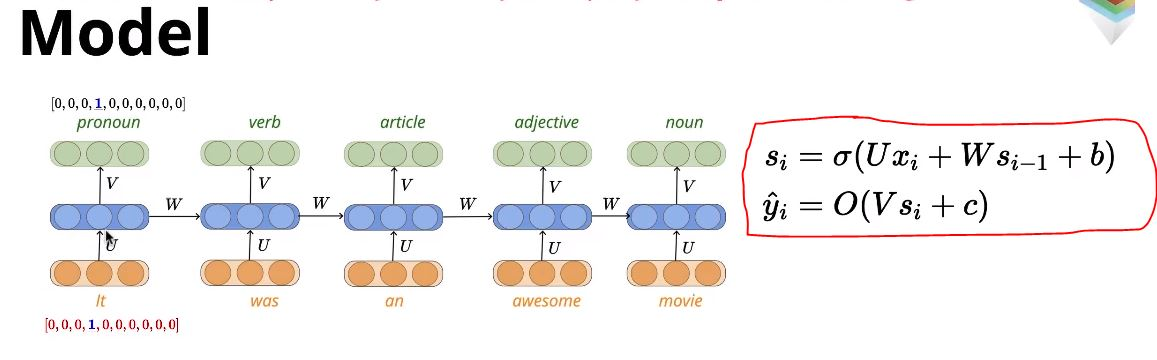

In [0]:
image_file = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/Pictures/Basic_RNN_model.JPG'
Image(image_file)

Note: Here the hidden size is to be given by the **user**

In [17]:
class RNN_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_net, self).__init__()
    self.hidden_size = hidden_size
    self.rnn_cell = nn.RNN(input_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, input_, hidden = None, batch_size = 1):
    out,hidden = self.rnn_cell(input_,hidden)
    output = self.h2o(hidden.view(-1,self.hidden_size))
    output = self.softmax(output)
    return output, hidden
  
  # for the initial input (letter) we dont have the hidden layer ouputs of the previous layer
  # hence this function will be used to initiate the hidden layer for the first input
  def init_hidden(self, batch_size=1):
    return torch.zeros(1,batch_size, self.hidden_size)
  
  
  
n_hidden = 128
n_letters = len(ascii_letters)
net = RNN_net(n_letters, n_hidden, len(languages))
net

RNN_net(
  (rnn_cell): RNN(55, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

- Since we are using the logarithm on softmax, we will get numbers in [-inf, 0], since log(0)=-inf and log(1)=0.
- We can get the probabilities back by using **torch.exp(output)**.

## 6. Evaluation of the model

In [0]:
# simple steps for forward pass

X_input = torch.rand(size=(1,1,55))
## input to hidden
rnn_cell = nn.RNN(55,128)
out,hidden = rnn_cell(X_input)

## hidden to output
h20 = nn.Linear(128,18)
output = h20(out).view(1,-1)
print(output.size())
print(output)

softmax = nn.LogSoftmax(dim=1)
final_output = softmax(output)
print(final_output)

# evaluation of loss
enc_lang = encode_language('Russian')
output, hidden = net(X_input)
criterion = nn.NLLLoss()
criterion(output,enc_lang)

torch.Size([1, 18])
tensor([[ 0.0624, -0.1801, -0.1369, -0.0927, -0.1042, -0.0660,  0.0475,  0.1664,
         -0.2141, -0.0921,  0.0904, -0.2766, -0.0454, -0.0344,  0.0689, -0.0096,
         -0.2172, -0.1311]], grad_fn=<ViewBackward>)
tensor([[-2.7701, -3.0126, -2.9694, -2.9252, -2.9367, -2.8985, -2.7850, -2.6661,
         -3.0466, -2.9246, -2.7421, -3.1091, -2.8779, -2.8668, -2.7636, -2.8421,
         -3.0497, -2.9635]], grad_fn=<LogSoftmaxBackward>)


tensor(2.7906, grad_fn=<NllLossBackward>)

In [0]:
# dataloader
def dataloader(n_names, X_, Y_):
  to_ret = []
  for i in range(n_names):
    index = np.random.randint(len(X_))
    name, label = X_[index], Y_[index]
    to_ret.append((name,label,encode_name(name),encode_language(label)))
  return to_ret

for name,label,i,y in dataloader(2,X_train,Y_train):
  print(name)

Jirinovsky
Lovett


In [0]:
%%time 
def infer_model(net,name):
  net.eval()
  hidden = net.init_hidden()
  encoded = encode_name(name)
  for i in range(encoded.size()[0]):
    name_encode = encoded[i].view(1,1,-1)
    output,hidden = net(name_encode, hidden = hidden)
    
  return output

def evaluation(net, n_points, k, X_, Y_):
  data = dataloader(n_points,X_,Y_)
  correct = 0
  for name,label,encoded_name, encoded_lang in data:
    output = infer_model(net,name)
    
    val,indices = output.topk(k)
    
    if encoded_lang in indices:
      correct += 1
      
  return correct/n_points
  
evaluation(net, 2000, 1, X_train, Y_train)

CPU times: user 2.43 s, sys: 50.9 ms, total: 2.48 s
Wall time: 2.49 s


In [0]:
packed_sequence,ground_truth = batch_seq_data(X_train,Y_train,n_points=2,device='cpu', verbose=False)

n_hidden = 128
n_letters = len(ascii_letters)
net = RNN_net(n_letters, n_hidden, len(languages))
hidden = net.init_hidden()

rnn_cell = nn.RNN(55,128)
forward1 = rnn_cell(packed_sequence)

output,hidden = forward1
h20 = nn.Linear(n_hidden,n_languages)
forward2 = h20(hidden.view(-1,n_hidden))
forward2.size()

torch.Size([2, 18])

## 7. Training the model


1. This is a sequence learning problem where we have to learn the sequence of letters in a given name and classify the name into language
2. while training the model we have to iterate over the one-hot encoded letters and compute the loss
3. then backpropagate the loss compute the gradient
4. Once the backpropagation is done for every letter in the sequence of a name then we update the weights  

### 7.1 Basic setup

In [0]:
name,language, encoded_name, encoded_lang = dataloader(1,X_train,Y_train)[0]
print(name,language)

hidden = net.init_hidden()
for i in range(encoded_name.size()[0]):
  output, hidden = net(encoded_name[i].view(1,1,-1),hidden=hidden)

Mndjoyan Russian


In [0]:
%%time
def train_model(net, opt, criterion, n_points):
  #opt.zero_grad()
  data_ = dataloader(n_points, X_train,Y_train)
  total_loss = 0
  for name, label, encoded_name, encoded_lang in data_:
    hidden = net.init_hidden()
    
    for i in range(encoded_name.size()[0]):  # iterating over the sequence of letters in a name 
      output,hidden = net(encoded_name[i].view(1,1,-1),hidden=hidden)
      loss = criterion(output,encoded_lang)
      loss.backward(retain_graph=True)

    total_loss += loss

  opt.step()
  
  return total_loss/n_points  # return the average loss

criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_model(net, opt, criterion, 200)

CPU times: user 1.07 s, sys: 76.5 ms, total: 1.15 s
Wall time: 1.16 s


In [0]:
%%time
def train_batch_model(net, opt, criterion, n_points):
    
    opt.zero_grad()
    loss = 0
    
    names_rep, lang_rep = batch_seq_data(X,Y,n_points=n_points,device='cpu', verbose=False)
    hidden = net.init_hidden()
    output, hidden = net(names_rep)
    
    loss = criterion(output, lang_rep)
    loss.backward(retain_graph=True)        
    opt.step()       
            
    return loss
  
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_batch_model(net, opt, criterion, 200)

'
CPU times: user 32.5 ms, sys: 3.94 ms, total: 36.4 ms
Wall time: 42.8 ms


1. Retain Graph function

**RuntimeError**: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

2. Difference between cross entropy loss and Negtive log likelihood loss (NLLLoss) 
-If our model outputs the softmax of the last layer then NLLLoss should be used otherwise we should use cross entropy loss function

In [0]:
## Evaluation of the model

evaluation(net, 1000, 1, X_test, Y_test)

0.492

### 7.2 Full setup for training

In [0]:
def train_setup(net,lr=0.0005, n_batches=100, batch_size=200, momentum=0.9, display_freq = 5):

  criterion = nn.NLLLoss()
  opt = optim.Adam(net.parameters(), lr=lr)
  loss = np.zeros(n_batches+1)
  for i in tqdm_notebook(range(n_batches),unit=' Batch',total=n_batches):
    loss[i+1] = (loss[i]*i + train_model(net, opt, criterion, batch_size))/(i + 1)
    if i % display_freq == 0:
      clear_output(wait=True)
      plt.figure()
      plt.plot(loss[1:i],'-*')
      plt.title('Training of Recurrent Neural Network')
      plt.xlabel('Iteration')
      plt.ylabel('Log Loss')
      plt.show() 
      
  print('Top 1 accuracy:',evaluation(net,1000,1,X_test,Y_test), '| Top 2 accuracy:',evaluation(net,1000,2,X_test,Y_test))
  
    
def train_batch_setup(net,lr=0.0005, n_batches=100, batch_size=200, momentum=0.9, display_freq = 5):

  criterion = nn.NLLLoss()
  opt = optim.Adam(net.parameters(), lr=lr)
  loss = np.zeros(n_batches+1)
  for i in tqdm_notebook(range(n_batches),unit=' Batch',total=n_batches):
    loss[i+1] = (loss[i]*i + train_batch_model(net, opt, criterion, batch_size))/(i + 1)
    if i % display_freq == 0:
      clear_output(wait=True)
      plt.figure()
      plt.plot(loss[1:i],'-*')
      plt.title('Training of Recurrent Neural Network')
      plt.xlabel('Iteration')
      plt.ylabel('Log Loss')
      plt.show() 
      
  print('Top 1 accuracy:',evaluation(net,1000,1,X_test,Y_test), '| Top 2 accuracy:',evaluation(net,1000,2,X_test,Y_test))

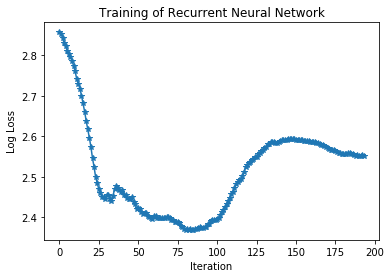

Top 1 accuracy: 0.484 | Top 2 accuracy: 0.647
CPU times: user 2min 4s, sys: 15.5 s, total: 2min 19s
Wall time: 2min 14s


In [0]:
%%time 
n_hidden = 128
lr = 0.0005

net = RNN_net(n_letters, n_hidden, len(languages))
train_setup(net, lr=lr,n_batches=200, batch_size = 100)

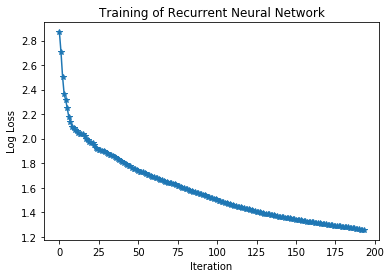

 
Top 1 accuracy: 0.721 | Top 2 accuracy: 0.812
CPU times: user 14.9 s, sys: 6.58 s, total: 21.5 s
Wall time: 13.8 s


In [0]:
%%time 
n_hidden = 128
lr = 0.005

criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

net = RNN_net(n_letters, n_hidden, len(languages))
train_batch_setup(net, lr=lr,n_batches=200, batch_size = 100)

## 8. LSTM models

Long short-term memory - used to overcome the vanishing and exploding of gradients in the sequence learning models. 

It uses selective read, write and forget algorithms to prevent the gradients from vanishing or exploding

In [0]:
class LSTM_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(LSTM_net, self).__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, input_, hidden=None):
    out, hidden = self.lstm_cell(input_,hidden)
    output = self.h2o(hidden[0].view(-1,self.hidden_size))
    output = self.softmax(output)
    return output, hidden
  
  def init_hidden(self,batch_size=1):
    return (torch.zeros(1,batch_size,self.hidden_size), torch.zeros(1,batch_size,self.hidden_size))
    # one for the hidden state and one for the usual cell state which was also present in the simple RNN model                    

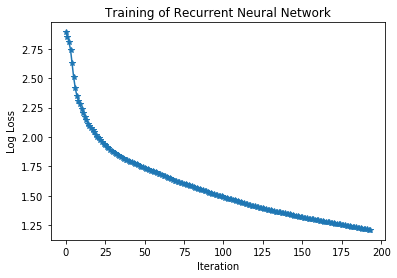

'
 
'
'
'
'
'
Top 1 accuracy: 0.724 | Top 2 accuracy: 0.853
CPU times: user 35 s, sys: 7.48 s, total: 42.5 s
Wall time: 35 s


In [0]:
%%time
hidden_size = 128
lstm_net = LSTM_net(n_letters, hidden_size, len(languages))
lr = 0.005
train_batch_setup(lstm_net, lr=lr,n_batches=200, batch_size = 512)

## 8. GRU - Gated Recurrent units 

Modified version of LSTM. here it doesnot have forget gate instead it has two gates input and output

In [0]:
class GRU_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(GRU_net, self).__init__()
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, input_, hidden=None):
    out, hidden = self.gru_cell(input_, hidden)
    output = self.h2o(hidden.view(-1,self.hidden_size))
    output = self.softmax(output)
    return output, hidden
  
  def init_hidden(self,batch_size=1):
    return torch.zeros(1,batch_size,self.hidden_size)
    # we have only state i.e. hidden state                

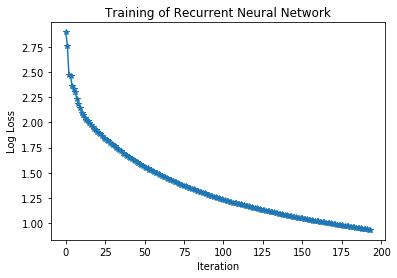

'
'
'
'
 
'
 
'
'
'
 
'
 
'
 
'
Top 1 accuracy: 0.796 | Top 2 accuracy: 0.892
CPU times: user 1min 37s, sys: 8.71 s, total: 1min 46s
Wall time: 1min 39s


In [0]:
%%time
hidden_size = 512
gru_net = GRU_net(n_letters, hidden_size, len(languages))
lr = 0.005
train_batch_setup(gru_net, lr=lr,n_batches=200, batch_size = 512)

## 9. Exercises

1. what is cell state and hidden state
2. plot the language wise accuaracy -> plot the confusion matrix
3. Optimize the model by modifying the hyperparameters
4. Observe gradient explosion at higher learning rates
5.  Increasing the performence by using GPU
6. Use batching while training

In [0]:
lang = 'Chinese'
lang_series = pd.Series(Y)
indices = list(lang_series[lang_series==lang].index)
low,high = min(indices),max(indices)
correct = 0

for name in X[low:high]:
  prediction = languages[torch.argmax(torch.exp(infer_model(net,name))).detach().numpy()]
  if prediction == lang:
    correct +=1

correct

148

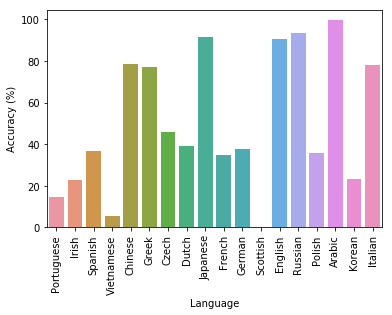

CPU times: user 1min, sys: 630 ms, total: 1min
Wall time: 1min


In [0]:
%%time
## accuracy per language 
def per_class_accuracy(model):
  output = {}
  lang_series = pd.Series(Y)
  
  for lang in languages:
    correct = 0    
    indices = list(lang_series[lang_series==lang].index)
    low,high = min(indices),max(indices)
   
    for name in X[low:high]:
      prediction = languages[torch.argmax(torch.exp(infer_model(model,name))).detach().numpy()]
      if prediction == lang:
        correct +=1
        
    output[lang] = correct/len(indices)*100
    
  return output


accuracies = per_class_accuracy(gru_net)
sns.barplot(list(accuracies.keys()),list(accuracies.values()))
plt.xticks(rotation=90)
plt.xlabel('Language')
plt.ylabel('Accuracy (%)')
plt.show() 

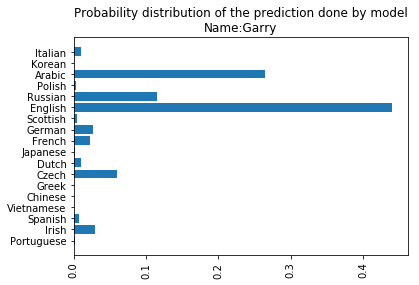

In [0]:
name = 'Garry'
plt.barh(languages,torch.exp(infer_model(net,name)).detach().numpy().flatten())
plt.title('Probability distribution of the prediction done by model\nName:'+name)
plt.xticks(rotation=90)
plt.show()

In [0]:
# automate the script
